In [112]:
import gzip
import os
import sys
import urllib
import matplotlib.image as mpimg
from PIL import Image

import code

import tensorflow.python.platform
import sys
import numpy
import tensorflow as tf
import argparse
import numpy as np
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.layers import Conv2D


In [130]:
NUM_CHANNELS = 3  # RGB images
PIXEL_DEPTH = 255
NUM_LABELS = 2
TRAINING_SIZE = 25
VALIDATION_SIZE = 5  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 16  # 64
NUM_EPOCHS = 100
RESTORE_MODEL = False  # If True, restore existing model instead of training a new one
RECORDING_STEP = 0
IMG_PATCH_SIZE = 16

## Some functions

In [200]:
def img_crop(im, w, h):
    '''
    Crop an image into patches of size w x h
    '''
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

def value_to_class(v):
    foreground_threshold = 0.25  # percentage of pixels > 1 required to assign a foreground label to a patch
    df = numpy.sum(v)
    if df > foreground_threshold:  # road
        return [0, 1]
    else:  # bgrd
        return [1, 0]

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    for i in range(1, num_images + 1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            # print("Loading " + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            print("File " + image_filename + " does not exist")

    num_images = len(imgs)
    IMG_WIDTH = imgs[0].shape[0]
    IMG_HEIGHT = imgs[0].shape[1]
    N_PATCHES_PER_IMAGE = (IMG_WIDTH / IMG_PATCH_SIZE) * (IMG_HEIGHT / IMG_PATCH_SIZE)

    img_patches = [
        img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)
    ] # list of list of patches, each list of patches corresponds to one image
    data = [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ] # flatten the list of patches

    return numpy.asarray(data)

def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    gt_imgs = []
    for i in range(1, num_images + 1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            # print("Loading " + image_filename)
            img = mpimg.imread(image_filename)
            gt_imgs.append(img)
        else:
            print("File " + image_filename + " does not exist")

    num_images = len(gt_imgs)
    gt_patches = [
        img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)
    ]
    data = numpy.asarray(
        [
            gt_patches[i][j]
            for i in range(len(gt_patches))
            for j in range(len(gt_patches[i]))
        ]
    )
    labels = numpy.asarray(
        [value_to_class(numpy.mean(data[i])) for i in range(len(data))]
    )

    # Convert to dense 1-hot representation.
    return labels.astype(numpy.float32)

# Data extraction and splitting

In [131]:
data_dir = os.getcwd() + '/dataset/training/'
data_filename = data_dir + "images/"
labels_filename = data_dir + "groundtruth/"

data = extract_data(data_filename, TRAINING_SIZE)
labels = extract_labels(labels_filename, TRAINING_SIZE)

In [132]:
# data splitting
train_split = 0.7
val_split = 0.15
test_split = 0.15

train_data = data[:int(train_split * len(data))]
train_labels = labels[:int(train_split * len(labels))]
val_data = data[int(train_split * len(data)) : int((train_split + val_split) * len(data))]
val_labels = labels[int(train_split * len(labels)) : int((train_split + val_split) * len(labels))]
test_data = data[int((train_split + val_split) * len(data)):]
test_labels = labels[int((train_split + val_split) * len(labels)):]




In [133]:
data.shape, train_data.shape, val_data.shape, test_data.shape

((15625, 16, 16, 3), (10937, 16, 16, 3), (2344, 16, 16, 3), (2344, 16, 16, 3))

In [123]:
train_data[0].shape, train_labels[0].shape

((16, 16, 3), (2,))

In [124]:
train_labels[0]

array([1., 0.], dtype=float32)

# Visualizing a patch 

(-0.5, 15.5, 15.5, -0.5)

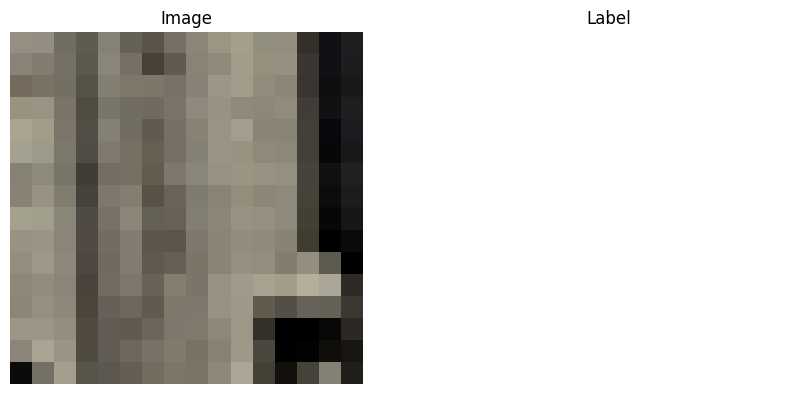

In [125]:
# Plot the image
import matplotlib.pyplot as plt

rows, cols = 1, 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
id = 4000
image = train_data[id]
label = train_labels[id]
mask = np.tile(train_labels[id][1], (16, 16))
# Display the image
axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis('off')  # Turn off the axes

# Display the label
axes[1].imshow(mask, cmap='gray',vmin=0, vmax=1)  # Use grayscale colormap for labels
axes[1].set_title("Label")
axes[1].axis('off')  # Turn off the axes

# 

# Balancing training data

In [134]:
# Balance the classes.
print("Balancing training data...")
c0 = np.sum(train_labels[:, 0] == 1) # Count the number of data points in class 0
c1 = np.sum(train_labels[:, 1] == 1) # Count the number of data points in class 1
print(f"Number of data points per class: c0 = {c0}, c1 = {c1}")
min_c = min(c0, c1)
idx0 = np.where(train_labels[:, 0] == 1)[0][:min_c] # Get the indices of the first class
idx1 = np.where(train_labels[:, 1] == 1)[0][:min_c] # Get the indices of the second class
balanced_indices = np.concatenate([idx0, idx1]) 
train_data = train_data[balanced_indices] 
train_labels = train_labels[balanced_indices]
    
print(f"Balanced dataset size: {train_data.shape[0]}")

Balancing training data...
Number of data points per class: c0 = 8154, c1 = 2783
Balanced dataset size: 5566


In [127]:
 # Define the model.
IMG_PATCH_SIZE = 16
NUM_CHANNELS = 3
NUM_LABELS = 2

In [135]:
''' NOT USED BUT MAYBE LATER IDK : didn't check if the results were better '''

# # Assuming IMG_PATCH_SIZE, NUM_CHANNELS, NUM_LABELS, SEED are defined elsewhere

# # Input layer
# model = models.Sequential()

# # First Convolutional Layer
# model.add(layers.Conv2D(
#     32, (5, 5), padding='same', 
#     input_shape=(IMG_PATCH_SIZE, IMG_PATCH_SIZE, NUM_CHANNELS), 
#     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1, seed=SEED),
#     bias_initializer=tf.keras.initializers.Zeros()
# ))

# # Second Convolutional Layer
# model.add(layers.Conv2D(
#     64, (5, 5), padding='same', 
#     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1, seed=SEED),
#     bias_initializer=tf.keras.initializers.Constant(0.1)
# ))

# # Flattening Layer before fully connected layers
# model.add(layers.Flatten())

# # Fully Connected Layer 1
# model.add(layers.Dense(
#     512, 
#     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1, seed=SEED),
#     bias_initializer=tf.keras.initializers.Constant(0.1)
# ))

# # Fully Connected Layer 2 (output layer)
# model.add(layers.Dense(
#     NUM_LABELS, 
#     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1, seed=SEED),
#     bias_initializer=tf.keras.initializers.Constant(0.1)
# ))

# # Print model summary to verify the architecture
# model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 16, 16, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,443,842 (32.21 MB)

 Trainable params: 8,443,842 (32.21 MB)

 Non-trainable params: 0 (0.00 B)

# Model definition and training

In [207]:
# Input dimensions
input_shape = (16, 16, 3)
num_classes = 2  # Road or not road (one-hot encoded)

# Model definition
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for one-hot encoding

# Model summary
model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,234 (590.76 KB)

 Trainable params: 151,042 (590.01 KB)

 Non-trainable params: 192 (768.00 B)

In [208]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [209]:
history = model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=30,  # Adjust the number of epochs based on your data
    batch_size=32,  # Adjust the batch size based on your hardware
    verbose=1  # Use 1 for progress bar display, 2 for one-line per epoch
)

Epoch 1/30


/Users/melina/.virtualenvs/base-venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5776 - loss: 0.9733 - val_accuracy: 0.1642 - val_loss: 0.9868
Epoch 2/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6594 - loss: 0.6543 - val_accuracy: 0.3055 - val_loss: 1.0986
Epoch 3/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6869 - loss: 0.5958 - val_accuracy: 0.4945 - val_loss: 0.8596
Epoch 4/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6960 - loss: 0.5793 - val_accuracy: 0.5887 - val_loss: 0.7126
Epoch 5/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7224 - loss: 0.5555 - val_accuracy: 0.6216 - val_loss: 0.6616
Epoch 6/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7377 - loss: 0.5260 - val_accuracy: 0.6169 - val_loss: 0.6567
Epoch 7/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7565 - loss: 0.5055 - val_accuracy: 0.6152 - val_loss: 0.6616
Epoch 8/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7668 - loss: 0.4884 - val_accuracy: 0.660

# Predictions

In [210]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=32, verbose=1)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7333 - loss: 0.6722


In [171]:
predictions = model.predict(test_data)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [183]:
predictions

array([[0.07444973, 0.9255503 ],
       [0.3896223 , 0.6103776 ],
       [0.9947699 , 0.00523012],
       ...,
       [0.98715883, 0.01284125],
       [0.9500959 , 0.0499042 ],
       [0.95292073, 0.0470792 ]], dtype=float32)

In [180]:
one_hot_encoded = np.zeros_like(predictions)  # Create an array of zeros with the same shape
one_hot_encoded[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1  # Set max index to 1


In [182]:
one_hot_encoded



array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Visualized some patches and ground truth vs predictions 

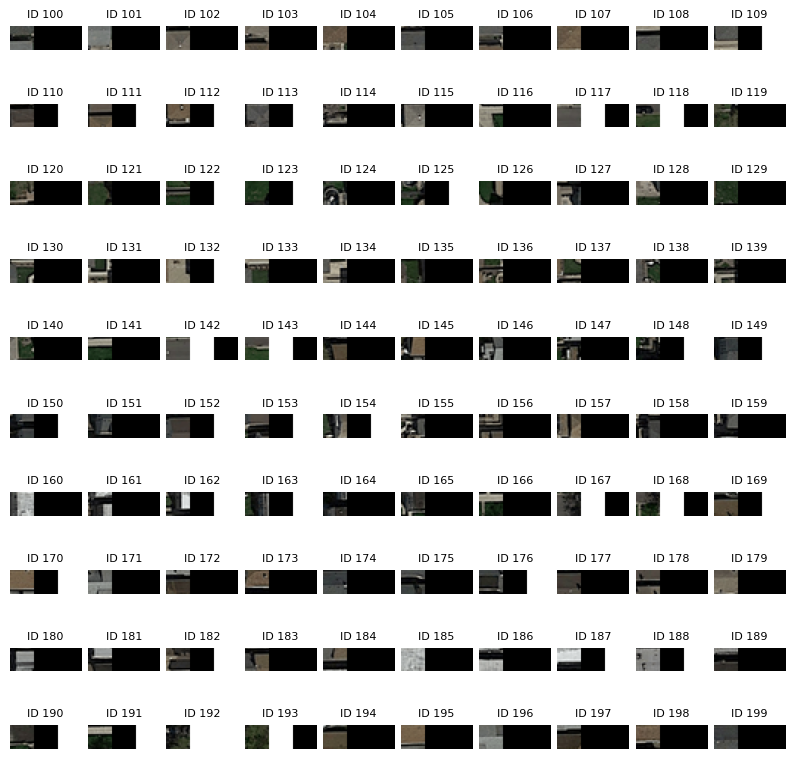

In [213]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters for the grid
rows, cols = 10, 10  # Number of rows and columns in the grid
start_id = 100  # Starting index in the test data
num_images = rows * cols  # Total number of images to display

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))  # Condensed grid

for i in range(num_images):
    idx = start_id + i
    row = i // cols  # Compute row index
    col = i % cols  # Compute column index
    
    # Extract data for the current index
    image = test_data[idx]
    label = test_labels[idx]
    pred = one_hot_encoded[idx]
    
    # Create the label and prediction masks
    mask = np.tile(label[1], (16, 16))
    mask_pred = np.tile(pred[1], (16, 16))
    
    # Combine image, label, and prediction as a single visualization
    combined = np.hstack((
        image, 
        np.stack([mask] * 3, axis=-1),  # Convert label to RGB for display
        np.stack([mask_pred] * 3, axis=-1)  # Convert prediction to RGB
    ))
    
    # Display the combined visualization
    axes[row, col].imshow(combined)
    axes[row, col].set_title(f"ID {idx}", fontsize=8)
    axes[row, col].axis('off')  # Turn off axes for cleaner visualization

# Adjust spacing to reduce whitespace
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


# On test data

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


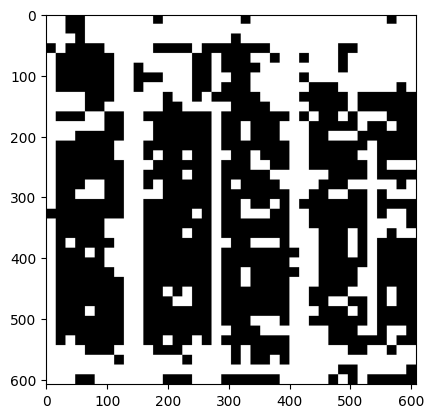

In [211]:
test_path = os.getcwd() + '/dataset/test_set_images/'
test_im_1 = mpimg.imread(test_path + 'test_1/test_1.png')
# cut into patches
test_patches = img_crop(test_im_1, IMG_PATCH_SIZE, IMG_PATCH_SIZE)
# predict
test_patches = np.array(test_patches)
test_predictions = model.predict(test_patches)
# one hot encoding
one_hot_encoded = np.zeros_like(test_predictions)
one_hot_encoded[np.arange(test_predictions.shape[0]), np.argmax(test_predictions, axis=1)] = 1
# reconstruct the image
reconstructed_image = np.zeros(test_im_1.shape)
idx = 0
for i in range(0, test_im_1.shape[1], IMG_PATCH_SIZE):
    for j in range(0, test_im_1.shape[0], IMG_PATCH_SIZE):
        reconstructed_image[j:j+IMG_PATCH_SIZE, i:i+IMG_PATCH_SIZE] = one_hot_encoded[idx][1]
        idx += 1
plt.imshow(reconstructed_image, cmap='gray')

# Predict and reconstruct image

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


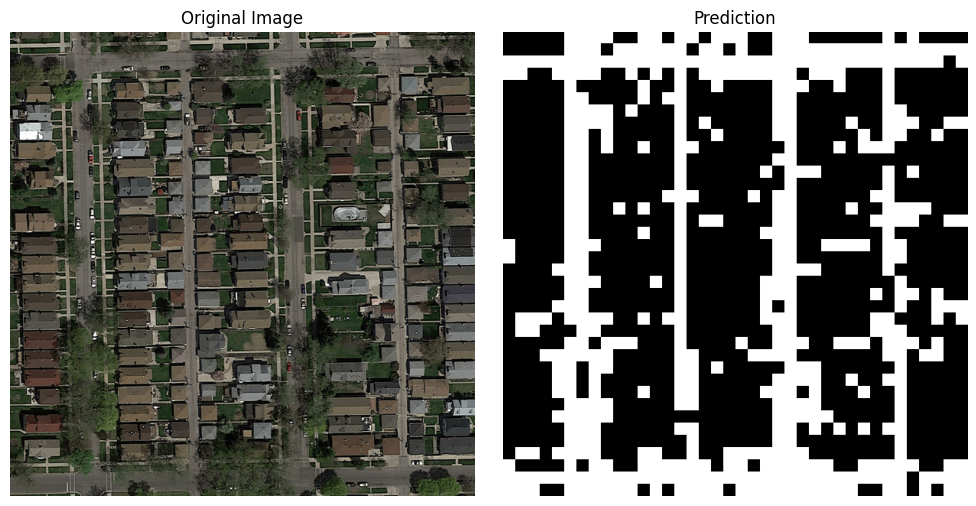

In [214]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model

# Define constants (example, adjust as necessary)
IMG_PATCH_SIZE = 16  # Size of the patches
test_path = os.getcwd() + '/dataset/test_set_images/'  # Path to test images


# Function to process a single test image and reconstruct predictions
def process_and_reconstruct(test_image_path):
    # Load the test image
    test_im = mpimg.imread(test_image_path)

    # Split the image into patches
    test_patches = img_crop(test_im, IMG_PATCH_SIZE, IMG_PATCH_SIZE)

    # Make predictions for each patch
    test_patches = np.array(test_patches)  # Convert to numpy array
    test_predictions = model.predict(test_patches)

    # One-hot encode predictions (assuming 2 classes)
    one_hot_encoded = np.zeros_like(test_predictions)
    one_hot_encoded[np.arange(test_predictions.shape[0]), np.argmax(test_predictions, axis=1)] = 1

    # Reconstruct the predicted image from the patches
    reconstructed_image = np.zeros(test_im.shape[:2])  # Empty image for reconstruction
    idx = 0
    for i in range(0, test_im.shape[1], IMG_PATCH_SIZE):
        for j in range(0, test_im.shape[0], IMG_PATCH_SIZE):
            reconstructed_image[j:j+IMG_PATCH_SIZE, i:i+IMG_PATCH_SIZE] = one_hot_encoded[idx][1]
            idx += 1
    
    return test_im, reconstructed_image

# Test the function on a single image
id = 30
test_im_path = test_path + f'test_{id}/test_{id}.png'
original_image, reconstructed_prediction = process_and_reconstruct(test_im_path)

# Plot the original and predicted images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')  # Turn off axes

# Display the reconstructed prediction
axes[1].imshow(reconstructed_prediction, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Prediction')
axes[1].axis('off')  # Turn off axes

plt.tight_layout()
plt.show()
